# Introduction

In this notebook, we use a Layerwise Learning technique [introduced by Andrea Skolik [1]](https://blog.tensorflow.org/2020/08/layerwise-learning-for-quantum-neural-networks.html) to efficiently train a quantum neural network without making any initial guesses about the structure that's neccessary to solve a certain learning task. To do this, we successively add layers to a QNN during training, which does not only make training faster, but also ensures a better signal-to-noise ratio compared to training the full circuit when done on real hardware.

It's well known that randomly initialized parametrized quantum circuits suffer from exponentially decaying gradients as circuits grow in size [2](https://www.nature.com/articles/s41467-018-07090-4.pdf). One strategy to avoid this is finding clever initialization schemes for deep circuits. Another approach which we take here instead focuses on the structure of the circuit, and shows how a deep parametrized circuit can be constructed during training. By training individual partitions of the circuit as it grows, we avoid the randomization effect that causes barren plateaus. This is mainly of importance on noisy intermediate-scale quantum (NISQ) devices, as these will suffer most from the unfavorable signal-to-noise ratio when running variational algorithms. As the gradients produced by circuits grow smaller, we need more and more measurements from a quantum device to accurately estimate them. When using layerwise learning (LL), gradients stay larger during training and we therefore need less measurements to get sufficient training signal for the optimizer. Additionally, we decrease the overall number of parameter updates, so that LL provides an efficient strategy to run variational algorithms on NISQ devices.

<br />
Possible cross-reference to localized learning methodology
<br /><br /><br /><br />

LL works in two phases as shown in the figure below:

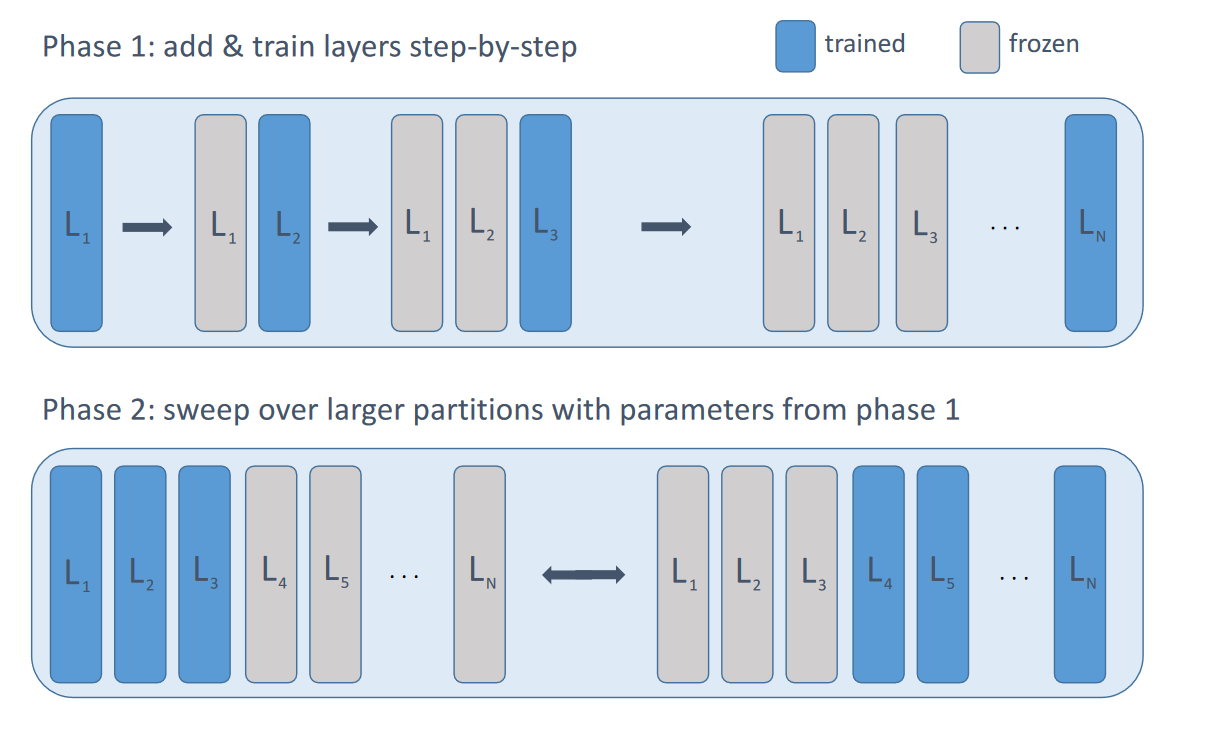

In the first phase, we start training with a small number of layers and train those for a fixed number of epochs. After that, we add another set of layers and freeze the parameters of the previous step's layers. We repeat this process until the desired depth is reached. In phase two, we perform additional optimization sweeps over larger subsets of the layers using the final circuit configuration from phase one. The parameters from this circuit give us a good starting point to optimize quarters, halves, or even the full circuit without initializing on a barren plateau.

This kind of learning scheme can be used for various types of learning tasks and input data, so long as the QNN structure allows iteratively building the circuits. In this notebook we look at a simple example of classifying MNIST digits with randomly generated layers.

[1] Layerwise learning for quantum neural networks, A. Skolik, J. R. McClean, M. Mohseni, P. van der Smagt, and M. Leib, https://arxiv.org/pdf/2006.14904.pdf

[2] Barren plateaus in quantum neural network training landscapes, J. R. McClean, S. Boixo, V. N. Smelyanskiy, R. Babbush, and H. Neven, Nature Communications 9 (2018) https://www.nature.com/articles/s41467-018-07090-4.pdf

# Setup

In [ ]:
!pip install --upgrade tensorflow==2.7.0

In [ ]:
!pip install tensorflow-quantum

     |████████████████████████████████| 10.5 MB 11.7 MB/s 
     |████████████████████████████████| 541 kB 73.4 MB/s 
     |████████████████████████████████| 6.1 MB 69.1 MB/s 
     |████████████████████████████████| 100 kB 11.3 MB/s 
     |████████████████████████████████| 90 kB 11.2 MB/s 
     |████████████████████████████████| 90 kB 12.6 MB/s 
     |████████████████████████████████| 1.8 MB 65.8 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 92 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |█████████████████████████████

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import collections
import itertools
import random
import copy

import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Data

In [ ]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [ ]:
# Generates sample data on the specified qubit in the simulated quantum computing processor( e.g. Bristlecone, Sycamore)
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───X^0.08─── Output: 1
Input: (0, 1): ───X^0.314─── Output: 1


# Layers

## Circuit Layers Generation

In [ ]:
def create_layer(qubits, layer_id):
    symbols = [sympy.Symbol(layer_id + '-' + str(i)) for i in range(len(qubits))]
    gate_set = [cirq.rx, cirq.ry, cirq.rz]

    gates = []
    symbol_gates = []
    for i, q in enumerate(qubits):
        chosen_gate = random.choice(gate_set)
        gates.append(chosen_gate(0)(q))
        symbol_gates.append(chosen_gate(symbols[i])(q))

    for control, target in zip(qubits, qubits[1:]):
        gates.append(cirq.CZ(control, target))
        symbol_gates.append(cirq.CZ(control, target))

    return gates, symbol_gates, symbols

## Define Layers

### The Cluster State

In [ ]:
def cluster_state_circuit(qubits):
    """Return a cluster state on the qubits in `qubits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(qubits))
    for this_bit, next_bit in zip(qubits, qubits[1:] + [qubits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


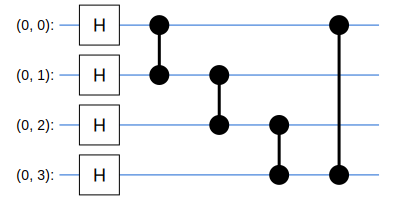

In [ ]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

### QCNN Layers

#### Single Qubit Unitary Circuit

In [ ]:
def one_qubit_unitary(qubit):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis.
    """
    return cirq.Circuit(
        cirq.X(qubit),
        cirq.Y(qubit),
        cirq.Z(qubit))

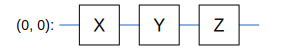

In [ ]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0)))

#### Two Qubit Unitary Circuit

In [ ]:
def two_qubit_unitary(qubits):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(qubits[0])
    circuit += one_qubit_unitary(qubits[1])
    circuit += [cirq.ZZ(*qubits)]
    circuit += [cirq.YY(*qubits)]
    circuit += [cirq.XX(*qubits)]
    circuit += one_qubit_unitary(qubits[0])
    circuit += one_qubit_unitary(qubits[1])
    return circuit

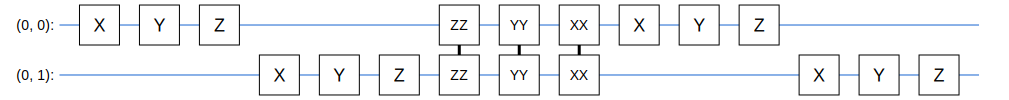

In [ ]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2)))

#### Two Qubit Pooling Circuit

In [ ]:
def two_qubit_pool(source_qubit, sink_qubit):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit)
    source_basis_selector = one_qubit_unitary(source_qubit)
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

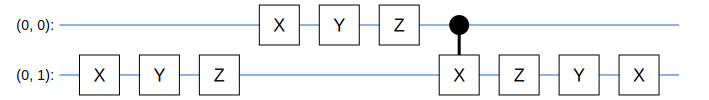

In [ ]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2)))

#### 1D Quantum Convolution

As in the [Cong and Lukin paper](https://arxiv.org/abs/1810.03787), define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [ ]:
def quantum_conv_circuit(qubits):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(qubits[0::2], qubits[1::2]):
        circuit += two_qubit_unitary([first, second])
    for first, second in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
        circuit += two_qubit_unitary([first, second])
    return circuit

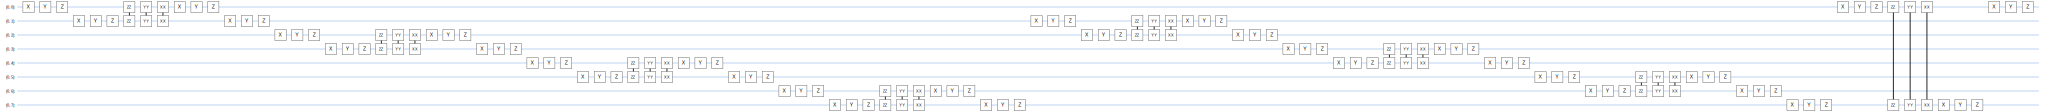

In [ ]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8)))

#### Quantum Pooling


A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [ ]:
def quantum_pool_circuit(source_qubits, sink_qubits):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_qubits, sink_qubits):
        circuit += two_qubit_pool(source, sink)
    return circuit

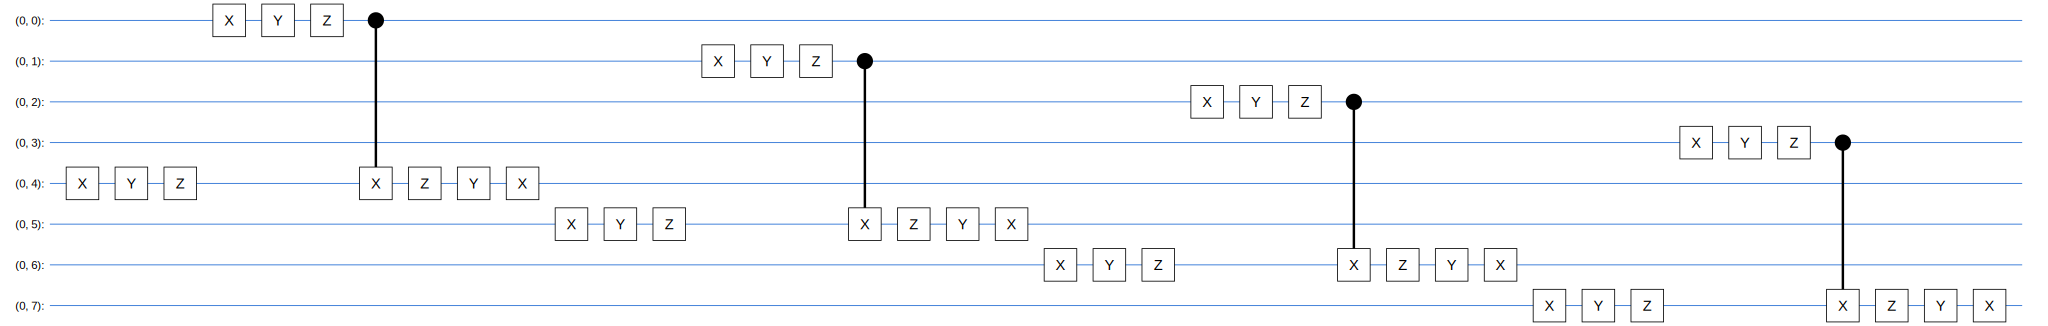

In [ ]:
test_qubits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_qubits[:4], test_qubits[4:]))

# Models

## Define QCNN Model

PHASE I
Now we will set up our training loop. We specify the number of qubits in the circuit, how many layer addition steps to perform, and how many layers to add in each step. The latter is a hyperparameter of our model that can be tuned for the learning task at hand. There is a trade-off between keeping the trained partitions as small as possible, but at the same time not too small to make significant progress on the learning task. You can play with the hyperparameters below to notice this difference. We are not going to freeze the previous layers in phase one in this implementation, but simply grow the circuit incrementally.

In [ ]:
n_qubits = 8
n_layer_steps = 5
n_layers_to_add = 2
''' data_qubits = cirq.GridQubit.rect(1, n_qubits) '''
''' readout = cirq.GridQubit(0, n_qubits-1) '''
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, n_qubits)
readout_operators = cirq.Z(cluster_state_bits[-1])

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []

# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    #remove dimensions of size 1 from the shape of the tensor
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

for layer_id in range(n_layer_steps):
  print("\nLayer:", layer_id)
  #Create sequence of alternating convolution and pooling operators which gradually shrink over time.
  circuit = cirq.Circuit()
  for i in range(n_layers_to_add):
    layer, symbol_layer, layer_symbols = create_layer(cluster_state_bits, f'layer_{layer_id}_{i}')
    layers.append(layer)
    symbol_layers.append(symbol_layer)
    symbols.append(layer_symbols)
    
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    circuit += quantum_conv_circuit(cluster_state_bits)
    circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    circuit += quantum_conv_circuit(cluster_state_bits[4:])
    circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    circuit += quantum_conv_circuit(cluster_state_bits[6:])
    circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
      
  circuit += symbol_layers

  # setup the Keras model
  qcnn_ll_model = tf.keras.Sequential()
  qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
  excitation_input_dual = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
  cluster_state_dual = tfq.layers.AddCircuit()(
      excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))
  qcnn_ll_model.add(tfq.layers.PQC(
      model_circuit = circuit,
      operators=readout_operators,
      differentiator=tfq.differentiators.ParameterShift(),
      initializer=tf.keras.initializers.Zeros))

  print(qcnn_ll_model.summary())
  #Uses Squared Hinge max margin cost function to penalize misclassification and 
  #classify those correct ones residing within margin of the decision boundary
  qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                metrics=[custom_accuracy])

  # set parameters to 0 for new layers
  qcnn_ll_model.set_weights([np.pad(weights, (0, n_qubits*n_layers_to_add))])

  qcnn_ll_model_1_history = qcnn_ll_model.fit(
      x=train_excitations,
      y=train_labels,
      batch_size=128,
      epochs=10,
      verbose=1,
      validation_data=(test_excitations, test_labels))

  qnn_results = qcnn_ll_model.evaluate(test_excitations, test_labels)
  training_history.append(qnn_results)

  weights = qcnn_ll_model.get_weights()[0]


Layer: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 1.1072 - custom_accuracy: 0.7411 - val_loss: 1.1109 - val_custom_accuracy: 0.7500
Epoch 2/5
1/1 [==============================] - 12s 12s/step - loss: 1.1072 - custom_accuracy: 0.7411 - val_loss: 1.1107 - val_custom_accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 13s 13s/step - loss: 1.1070 - custom_accuracy: 0.7411 - val_loss: 1.1102 - val_custom_accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 13s 13s/step - loss: 1.1064 - custom_accuracy: 0.7411 - val_loss: 1.

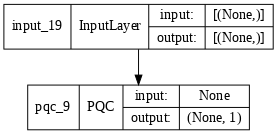

In [ ]:
# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_ll_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

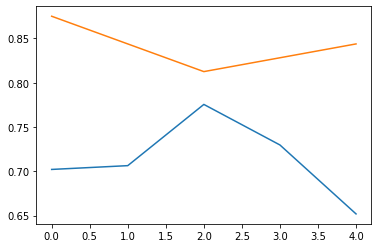

In [ ]:
plt.plot(training_history)

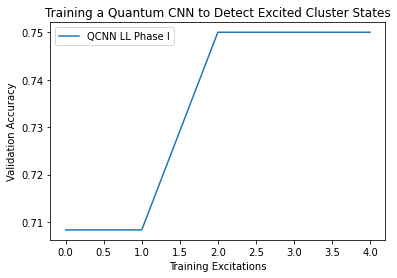

In [ ]:
plt.plot(qcnn_ll_model_1_history.history['val_custom_accuracy'], label='QCNN LL Phase I')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Excitations')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Phase II
After our circuit has grown to the specified size, we now use this as a starting point to train larger partitions. This means that we will split the circuit by specifiying a percentage of layers that should be trained as one contiguous set. In the example below, we will split the circuit in half, and then alternatingy train the two halfs for n_sweeps times.

To do this with TFQ, we need to keep track of the symbols associated with each gate, and only include the symbols of gates in the circuit configuration which we actually want to train.

In [ ]:
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 2
readout = cirq.GridQubit(0, n_qubits-1)

training_history = []

def train_partition(circuit, trained_weights):

    qcnn_ll_model = tf.keras.Sequential()
    qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    excitation_input_dual = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
    cluster_state_dual = tfq.layers.AddCircuit()(
      excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))
    qcnn_ll_model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_operators,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                  metrics=[custom_accuracy])

    print(qcnn_ll_model.summary())

    qcnn_ll_model.set_weights([trained_weights])
    qcnn_ll_model_2_history = qcnn_ll_model.fit(
        x=train_excitations,
        y=train_labels,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(test_excitations, test_labels))

    part_weights = qcnn_ll_model.get_weights()[0]

    qcnn_results = qcnn_ll_model.evaluate(test_excitations, test_labels)
    training_history.append(qcnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
    part_weights = train_partition(trained_circuit, trained_weights)
    weights[:n_partition_weights] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))

    trained_weights = weights[n_partition_weights:]
    untrained_weights = list(copy.copy(weights[:n_partition_weights][::-1]))
    untrained_layers = layers[:partition_size]

    trained_circuit = cirq.Circuit()
    trained_circuit += untrained_layers
    trained_circuit += symbol_layers[partition_size:]
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])

    part_weights = train_partition(trained_circuit, trained_weights)
    weights[n_partition_weights:] = part_weights


Sweep over partitions


Sweep 1, partition 1

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_10 (PQC)                (None, 1)                 40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1/1 [==============================] - 36s 36s/step - loss: 0.2136 - custom_accuracy: 0.9821 - val_loss: 0.2390 - val_custom_accuracy: 0.9792
Epoch 2/5
1/1 [==============================] - 30s 30s/step - loss: 0.2133 - custom_accuracy: 0.9911 - val_loss: 0.2335 - val_custom_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 28s 28s/step - loss: 0.2116 - custom_accuracy: 1.0000 - val_loss: 0.2305 - val_custom_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 28s 28s/step - loss: 0.2119 

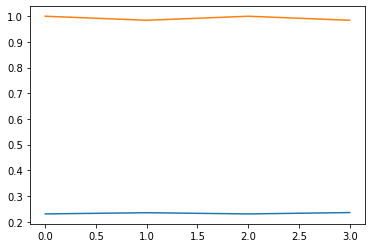

In [ ]:
plt.plot(training_history)

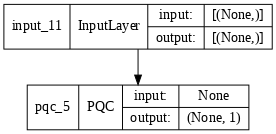

In [ ]:
# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_ll_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [ ]:
plt.plot(qcnn_ll_model_2_history.history['val_custom_accuracy'], label='QCNN LL Phase II')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Training Excitations')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

NameError: ignored

Phase III
Making adjustments to partition %s and sweeps. Should probably run this instead of Phase II instead of after Phase II to mitigate risk of overfitting, but as wee can see, there is over 62% improvement in training accuracy on the SPT dataset.

In [ ]:
partition_percentage = 0.25
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 4

def train_partition(circuit, trained_weights):

    qcnn_ll_model = tf.keras.Sequential()
    qcnn_ll_model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    qcnn_ll_model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_operators,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    qcnn_ll_model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                  metrics=[custom_accuracy])

    print(qcnn_ll_model.summary())

    qcnn_ll_model.set_weights([trained_weights])
    qcnn_ll_model.fit(x=train_excitations,
              y=train_labels,
              batch_size=128,
              epochs=10,
              verbose=1,
              validation_data=(test_excitations, test_labels))

    part_weights = qcnn_ll_model.get_weights()[0]

    qnn_results = qcnn_ll_model.evaluate(test_excitations, test_labels)
    training_history.append(qnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
    part_weights = train_partition(trained_circuit, trained_weights)
    weights[:n_partition_weights] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))

    trained_weights = weights[n_partition_weights:]
    untrained_weights = list(copy.copy(weights[:n_partition_weights][::-1]))
    untrained_layers = layers[:partition_size]

    trained_circuit = cirq.Circuit()
    trained_circuit += untrained_layers
    trained_circuit += symbol_layers[partition_size:]
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    trained_circuit += quantum_conv_circuit(cluster_state_bits)
    trained_circuit += quantum_pool_circuit(cluster_state_bits[:4], cluster_state_bits[4:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[4:])
    trained_circuit += quantum_pool_circuit(cluster_state_bits[4:6], cluster_state_bits[6:])
    trained_circuit += quantum_conv_circuit(cluster_state_bits[6:])
    trained_circuit += quantum_pool_circuit([cluster_state_bits[6]], [cluster_state_bits[7]])
    part_weights = train_partition(trained_circuit, trained_weights)
    weights[n_partition_weights:] = part_weights


Sweep over partitions


Sweep 1, partition 1

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_14 (PQC)                (None, 1)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
7/7 [==============================] - 19s 2s/step - loss: 0.6633 - custom_accuracy: 0.9018 - val_loss: 0.5050 - val_custom_accuracy: 0.9583
Epoch 2/10
7/7 [==============================] - 17s 2s/step - loss: 0.5482 - custom_accuracy: 0.9018 - val_loss: 0.4138 - val_custom_accuracy: 0.9583
Epoch 3/10
7/7 [==============================] - 17s 2s/step - loss: 0.4697 - custom_accuracy: 0.8929 - val_loss: 0.3725 - val_custom_accuracy: 0.9583
Epoch 4/10
7/7 [==============================] - 17s 2s/step - loss: 0.4276 

In [ ]:
# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_ll_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

NameError: ignored

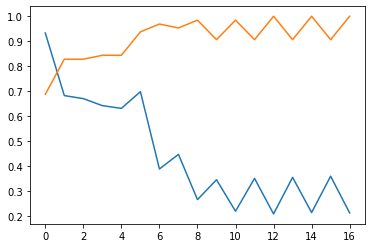

In [ ]:
plt.plot(training_history)